# Longshot bias in esports gaming

TO DO: Check Longshot bias in esports gaming

### Let's import the packages and data from Excel file

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pylab as plt
import warnings
warnings.filterwarnings('ignore')

In [73]:
df = pd.read_excel("WhichOddWins.xlsx", sheet_name="HA_Fave_2021", skiprows=[0])

### Preparing the data

In [74]:
df = df[["Div", "Date", "OddWins", "STD", "MAX", "MIN", "StakeBig", "WinOnBig", "StakeSmall", "WinOnSmall"]]

In [75]:
df['Year'] = pd.DatetimeIndex(df['Date']).year

In [76]:
df["ProfitOnBig"] = df["WinOnBig"] - df["StakeBig"]

In [77]:
df["ProfitOnSmall"] = df["WinOnSmall"] - df["StakeSmall"]

In [78]:
df = df.dropna()

In [79]:
# list of thresholds of standard deviation for filtering the data 
thresholds = [0.0, 0.7, 1.0, 1.5, 2.0, 2.5, 3.0, 5.0]

In [80]:
# Sanity check
df.tail()

,Div,Date,OddWins,STD,MAX,MIN,StakeBig,WinOnBig,StakeSmall,WinOnSmall,Year,ProfitOnBig,ProfitOnSmall
13109,League of Legends EU Masters,31 Mar 2021,Small,2.000,5.16,1.16,3.100962,0.000000,18.125000,21.025000,2021,-3.100962,2.900000
13110,League of Legends LCK,31 May 2016,Small,0.360,2.31,1.59,4.408397,0.000000,6.737288,10.712288,2016,-4.408397,3.975000
13111,League of Legends EU Masters,31 May 2017,Small,1.225,3.70,1.25,3.425926,0.000000,12.500000,15.625000,2017,-3.425926,3.125000
13112,League of Legends EU Masters,31 May 2017,Small,0.680,2.77,1.41,3.912429,0.000000,8.597561,12.122561,2017,-3.912429,3.525000
13113,League of Legends LCK,31 May 2017,Big,1.110,3.49,1.27,3.504016,12.229016,11.759259,0.000000,2017,8.725000,-11.759259


In [69]:
# Sanity check again
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13114 entries, 0 to 13388
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Div            13114 non-null  object 
 1   Date           13114 non-null  object 
 2   OddWins        13114 non-null  object 
 3   STD            13114 non-null  float64
 4   MAX            13114 non-null  float64
 5   MIN            13114 non-null  float64
 6   StakeBig       13114 non-null  object 
 7   WinOnBig       13114 non-null  float64
 8   StakeSmall     13114 non-null  float64
 9   WinOnSmall     13114 non-null  float64
 10  Year           13114 non-null  float64
 11  ProfitOnBig    13114 non-null  object 
 12  ProfitOnSmall  13114 non-null  float64
dtypes: float64(8), object(5)
memory usage: 1.4+ MB


In [70]:
# Sanity check again again
leagues = df["Div"].unique()

In [81]:
leagues

array(['league-of-legends-lcl', 'League of Legends Championship',
       'League of Legends EU Masters', 'League of Legends LCK',
       'Dota 2 Champions League', 'Dota 2 i-League', 'Starcraft',
       'league-of-legends-lpl', 'Counter-Strike ESL Pro League',
       'league-of-legends-cblol',
       'League of Legends European Championship',
       'League of Legends Oceanic Pro League 2020',
       'OverWatch OGN Overwatch APEX', 'OverWatch Pacific Championship',
       'OverWatch Premier Series', 'OverWatch APAC Premier',
       'overwatch-overwatch-league', 'OverWatch World Cup',
       'OverWatch Overwatch Contenders',
       'league-of-legends-mid-season-cup', 'league-of-legends-lec',
       'league-of-legends-lcs',
       'counter-strike-perfect-world-league-season-1',
       'League of Legends LDL', 'league-of-legends-ljl',
       'league-of-legends-tcl', 'league-of-legends-lco'], dtype=object)

-67.22621683523188
-134.81877919006425
-79.24634538810393
-89.10803084534679
-40.58935925105139
-19.420146510031653
-7.627197006298325
26.367622815464003
-268.31316947693847
-81.61273296037875
-42.136490618387995
-56.1092000804305
-21.062627778321424
-11.647429661409888
14.849643415874286
-2.717391304347828
-361.656906071713
10.668854359866131
45.97950423297249
36.032518392673246
-9.117742084371821
0.0
0.0
0.0
-64.50866572981434
-40.70430486194033
-6.879995593708859
12.486943992227342
1.0577491850364167
7.192465595888573
-2.909165302782325
0.0
38.107468200430304
20.560376765403934
2.2951766400636058
6.831262390428684
-20.461055999116212
-8.360750907300613
3.5246460651801357
0.0
-48.66743599065447
-75.2514028690786
-87.7039299528488
-34.64826474267918
-34.94140423092506
-8.868942037742473
-19.267537575524422
12.128566552485179
-67.2262168352319
-134.81877919006428
-79.24634538810395
-89.10803084534679
-40.589359251051384
-19.42014651003165
-7.627197006298325
26.367622815464003
-268.3131

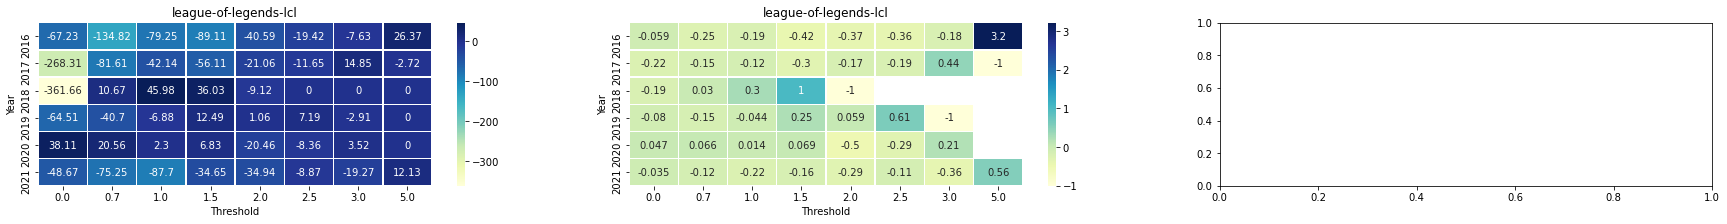

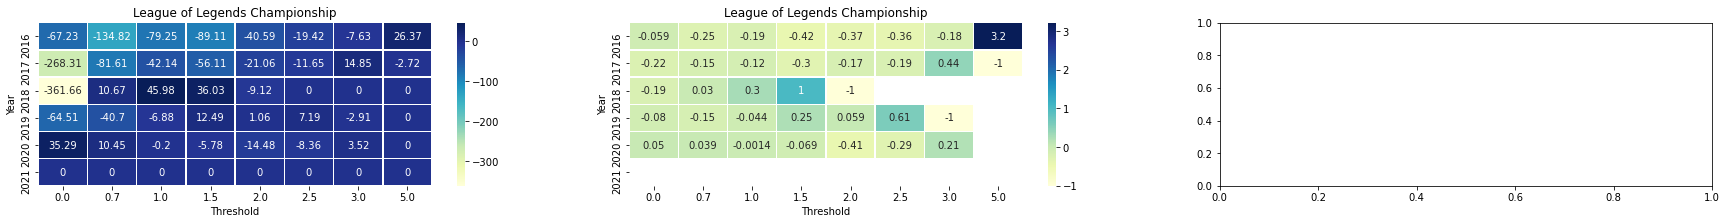

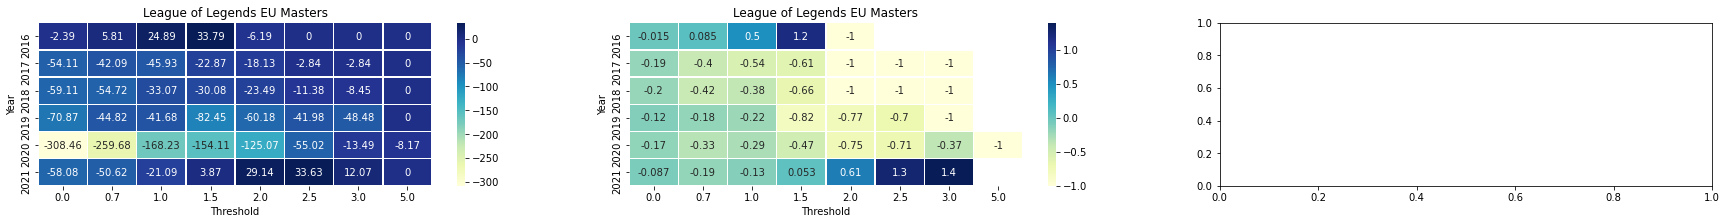

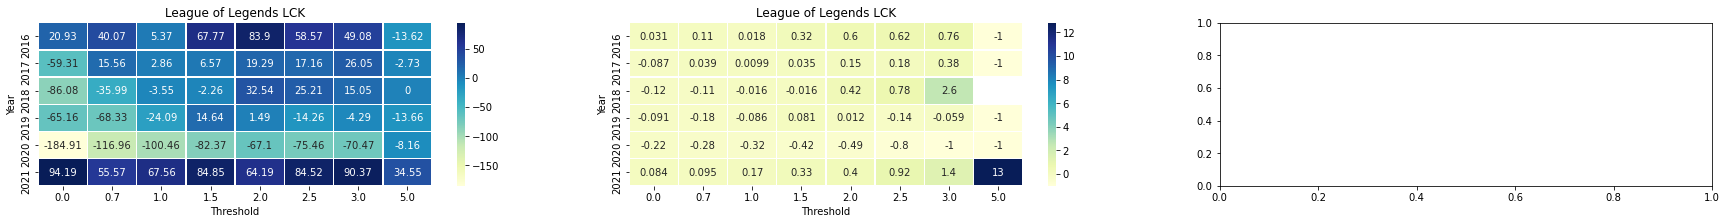

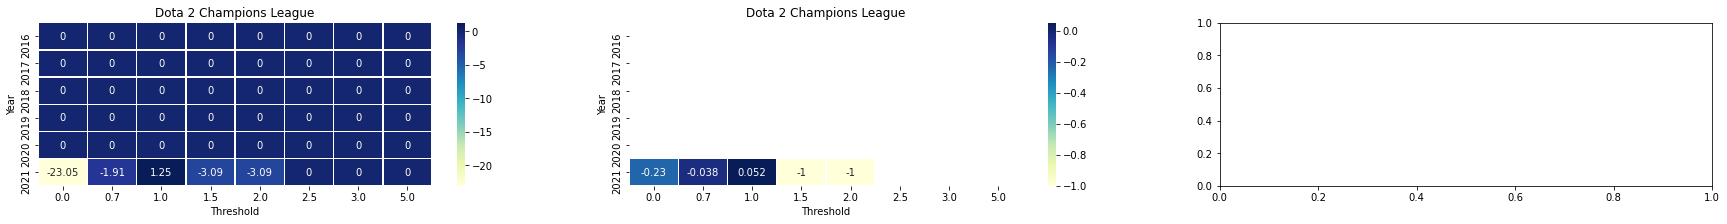

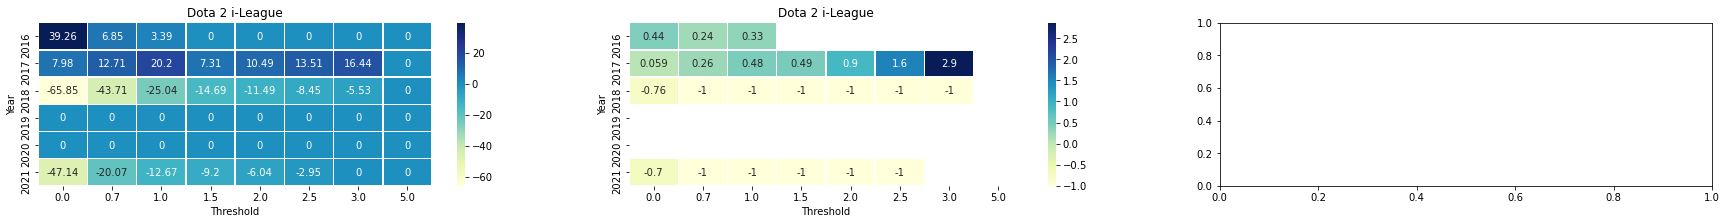

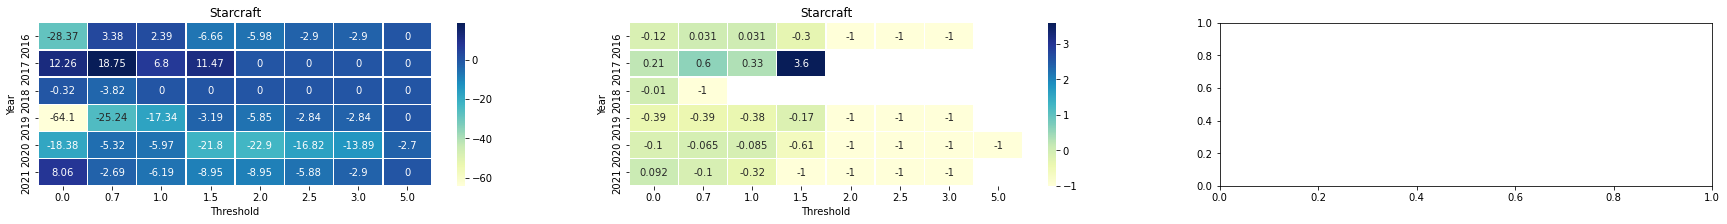

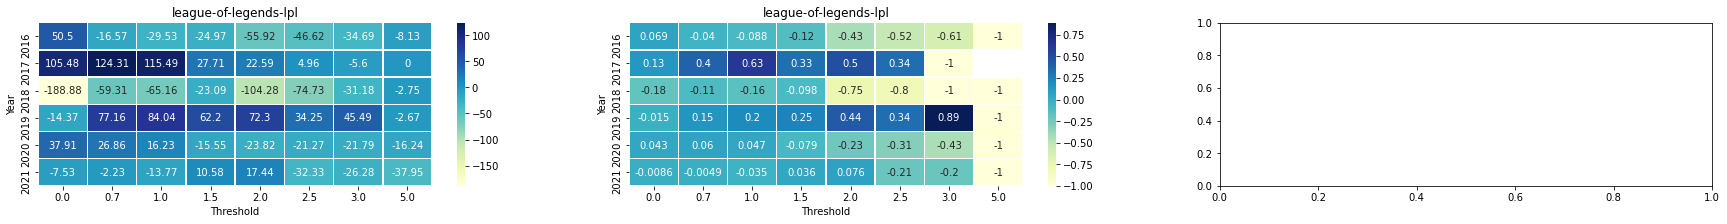

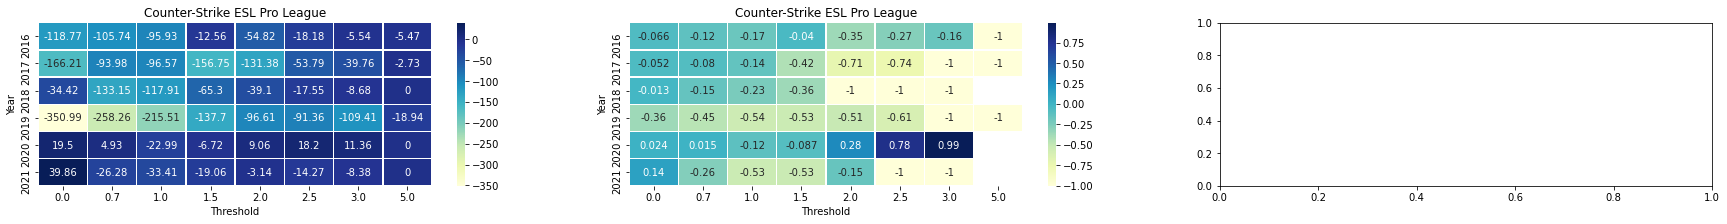

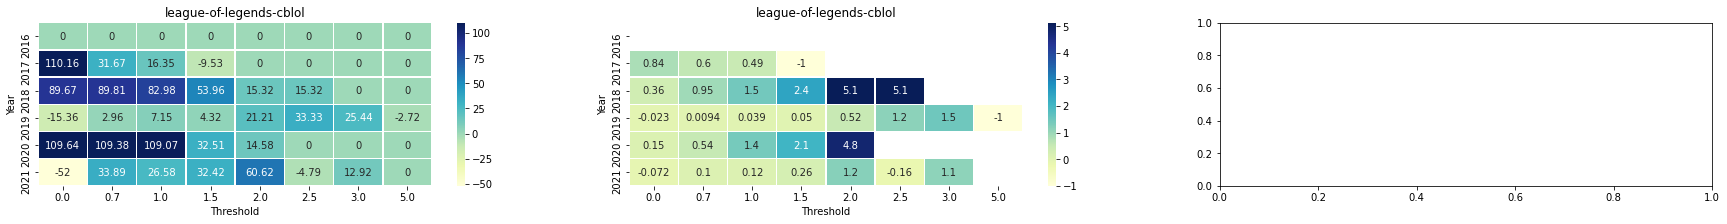

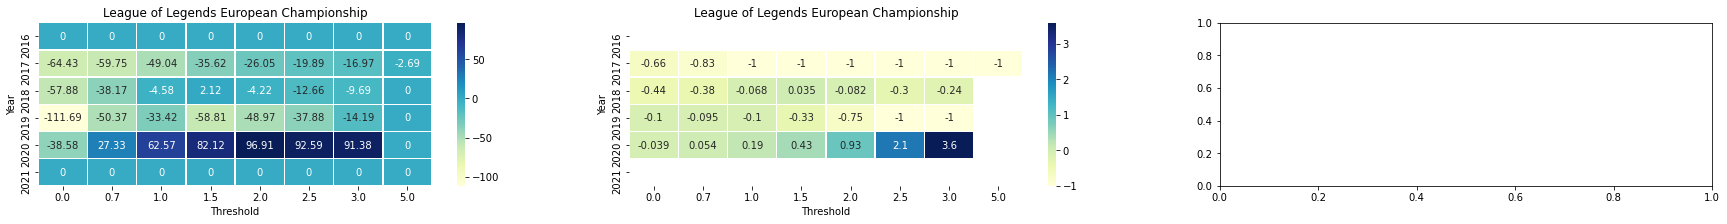

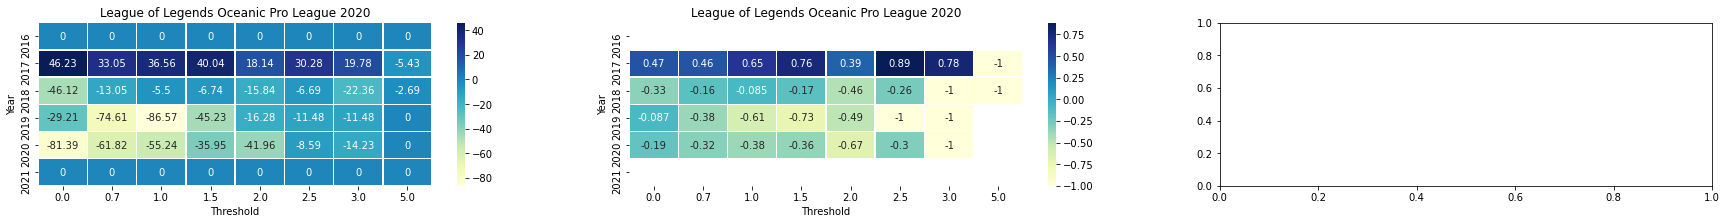

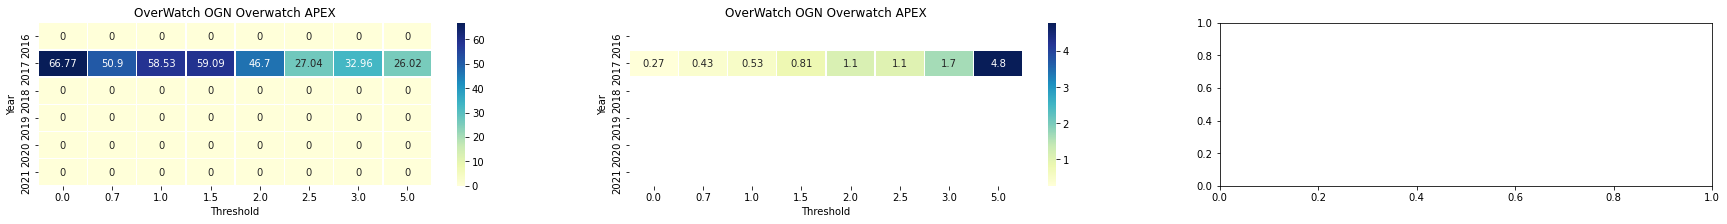

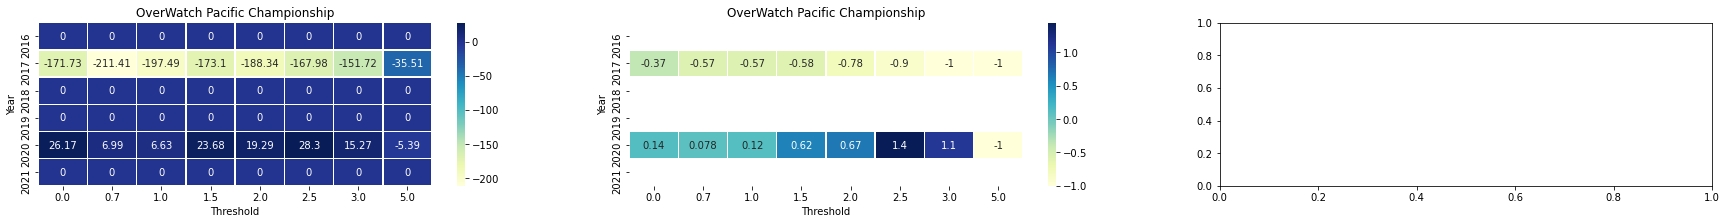

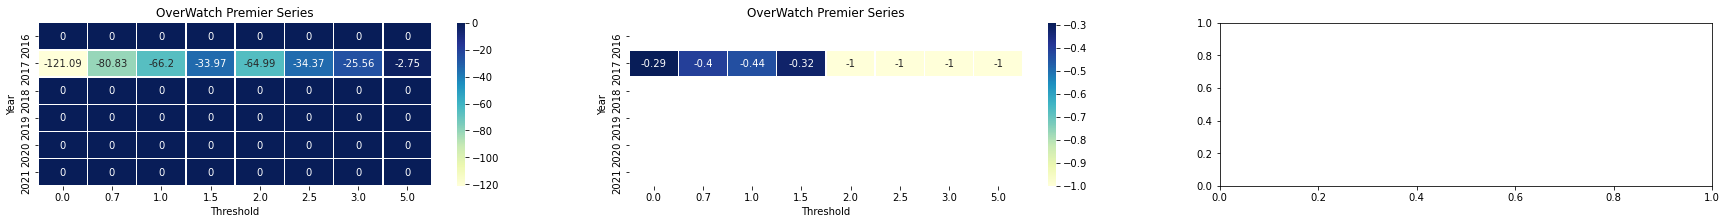

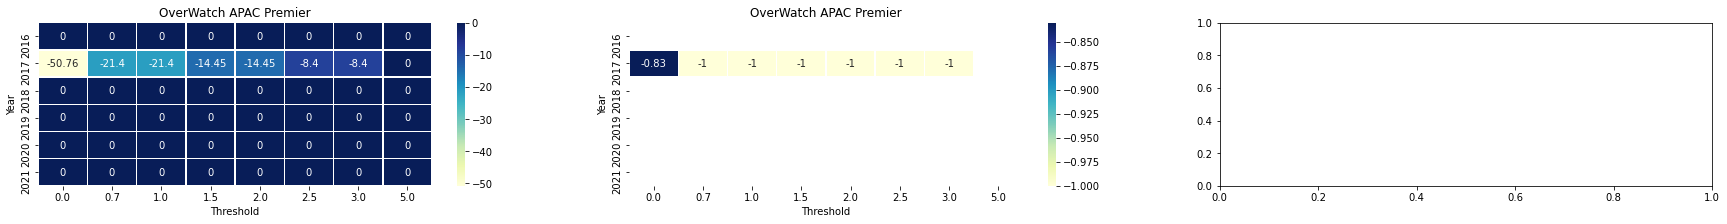

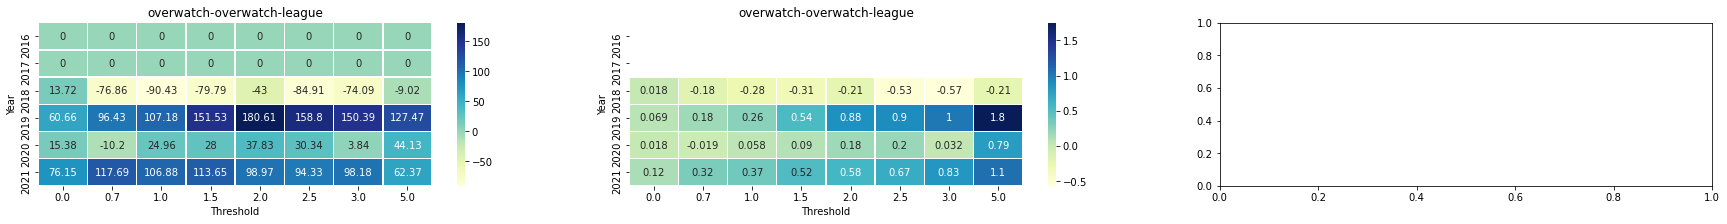

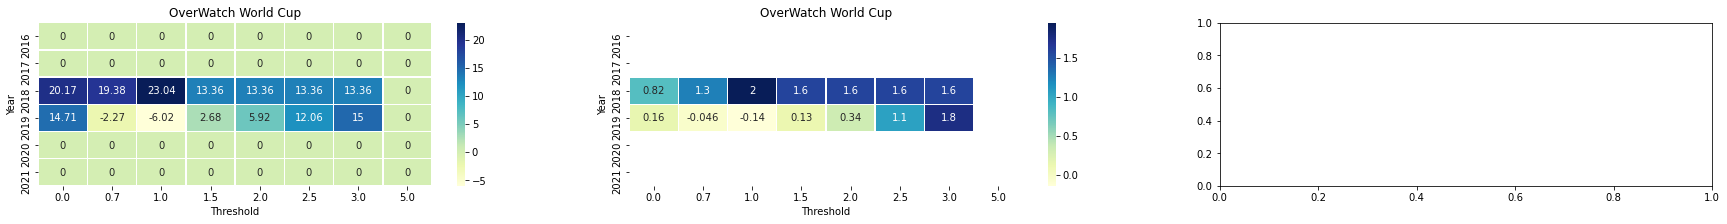

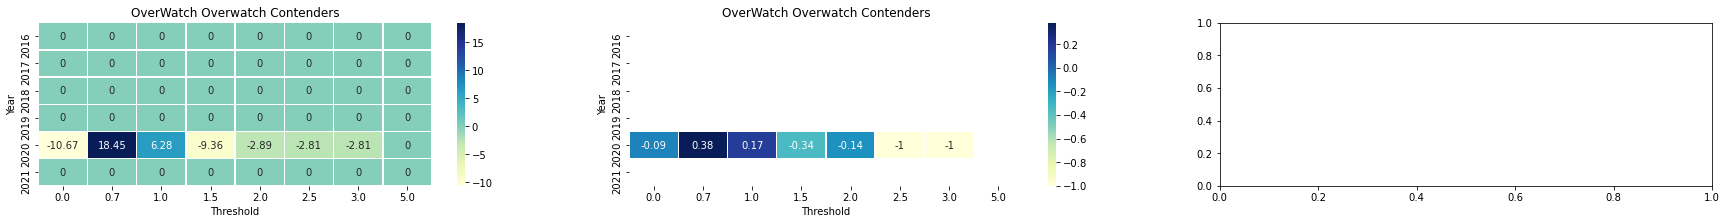

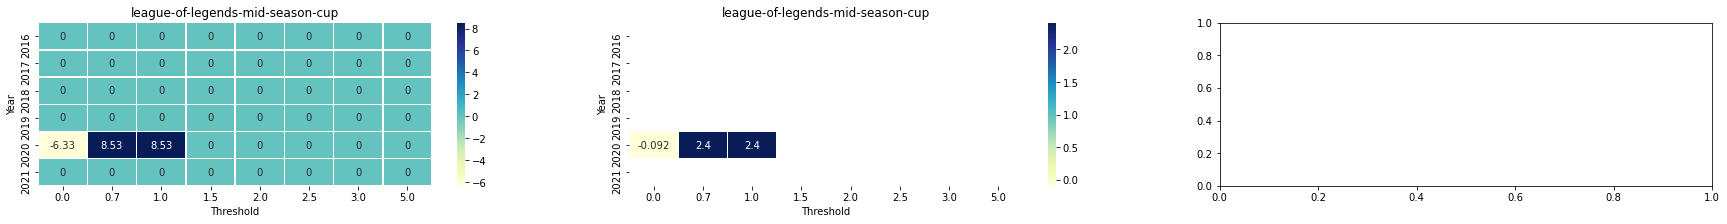

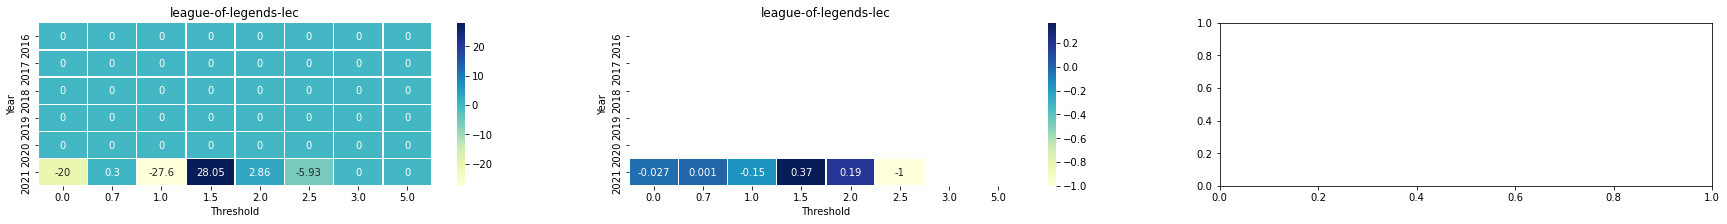

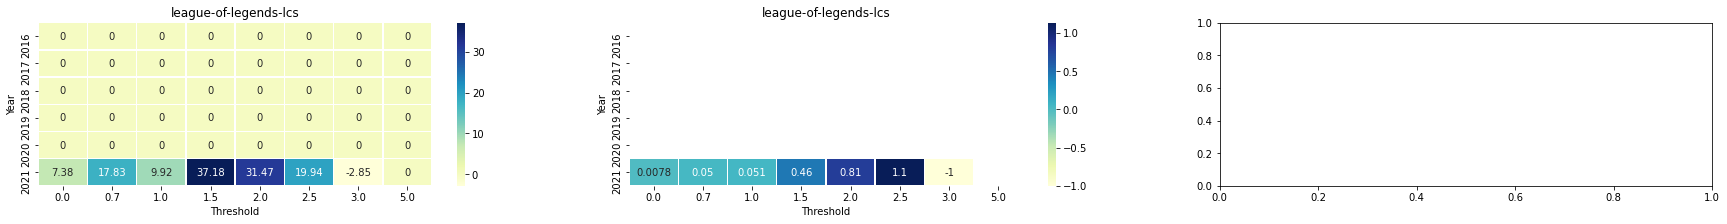

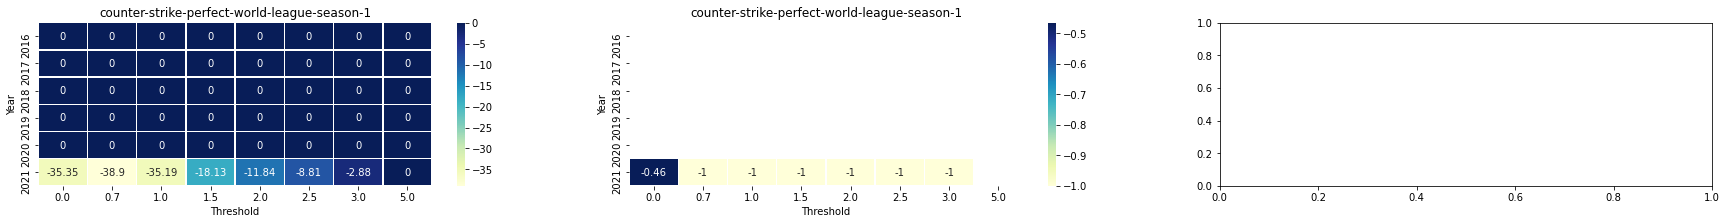

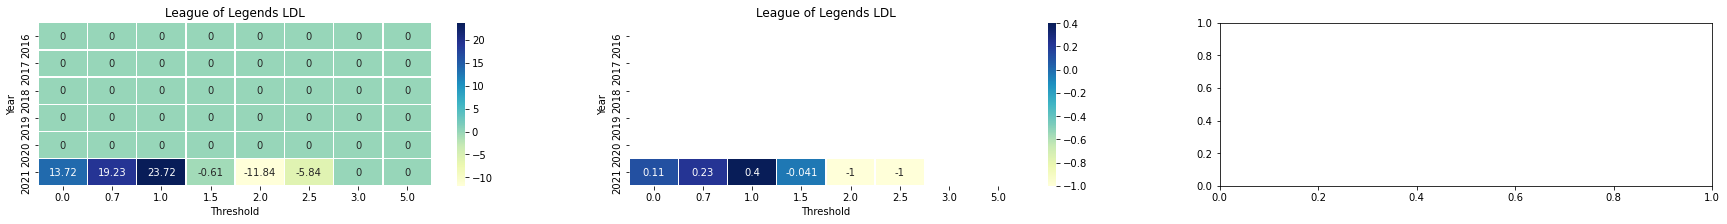

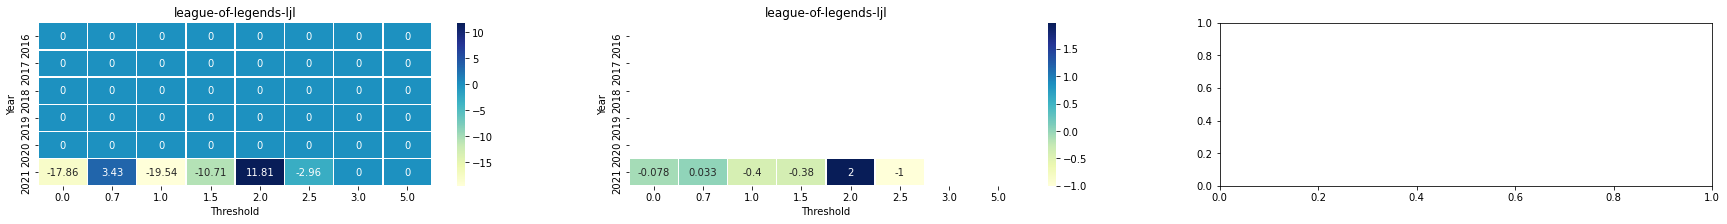

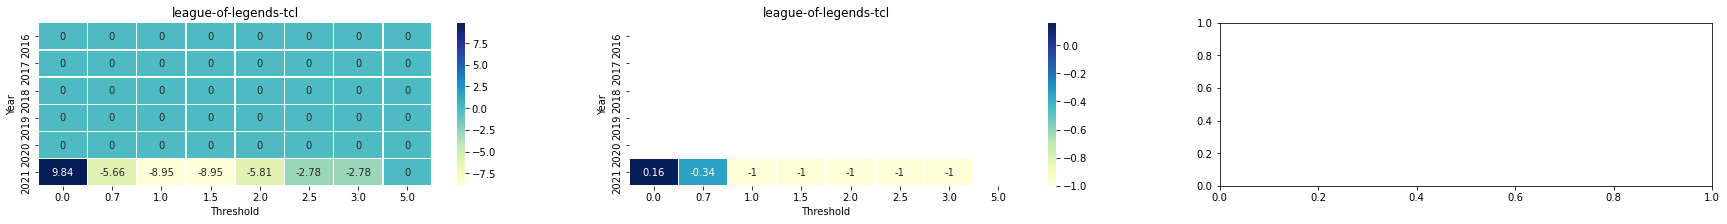

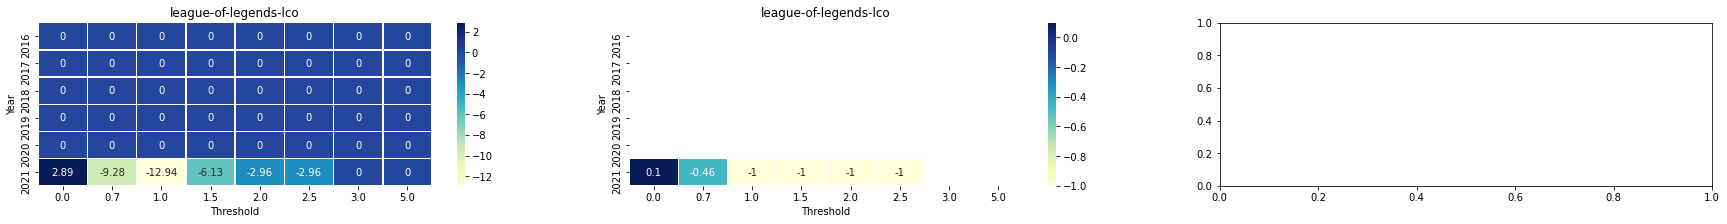

In [82]:
#BiggerOdds & Bigger than threshold:

i = 0
plt.rcParams["figure.figsize"] = (30,3)

for league in leagues:
    df_results = pd.DataFrame(columns=["Year", "Div", "Threshold", "ProfitOnBig", "Profit_pct", "Profit_cnt"])
    i += 1
    for years in range(2016, 2022):
        div = (df["Div"] == league)
        year = (df["Year"] == years)
        i += 1
        for threshold in thresholds:
            std_range = (df["STD"] >= threshold)
            df_filtered = df[year & div & std_range]
            profit = df_filtered["ProfitOnBig"].sum()
            profit_pct = profit / df_filtered["StakeBig"].sum()
            #profit_cnt = df_filtered["ProfitOnBig"].sum() / profit_pct
            new_row = pd.Series({"Year":years, "Div":league, "Threshold":threshold, "Profit":round(profit,2), "Profit_pct":profit_pct})
            df_results = df_results.append(new_row, ignore_index=True)
            i += 1
    fig, ax = plt.subplots(1,3)
    sns.heatmap(df_results.pivot("Year", "Threshold", "Profit"), cmap="YlGnBu", annot=True, fmt="g", linewidths=0.5, ax=ax[0]).set(title=league)
    sns.heatmap(df_results.pivot("Year", "Threshold", "Profit_pct"), cmap="YlGnBu", annot=True, linewidths=0.5, ax=ax[1]).set(title=league)
    #sns.heatmap(df_results.pivot("Year", "Threshold", "Profit_cnt"), cmap="YlGnBu", annot=True, fmt="g", linewidths=0.5, ax=ax[2]).set(title=league)
    fig.show()
    

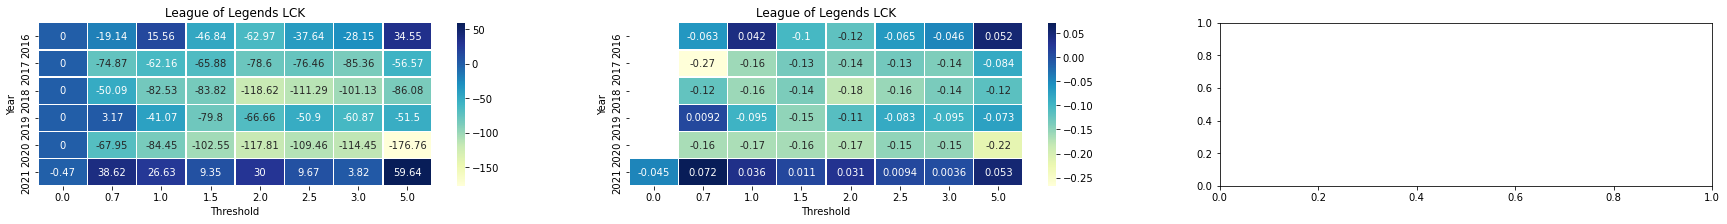

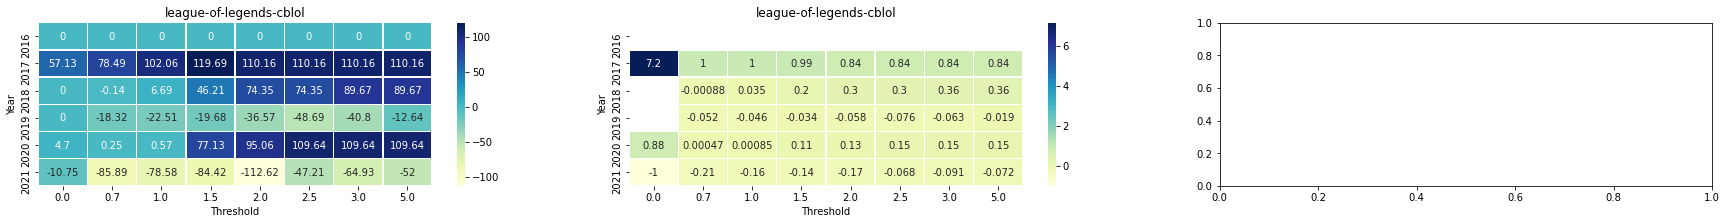

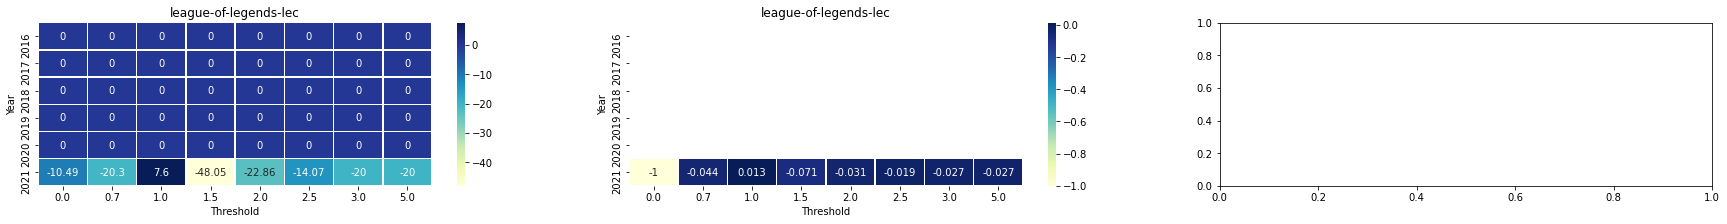

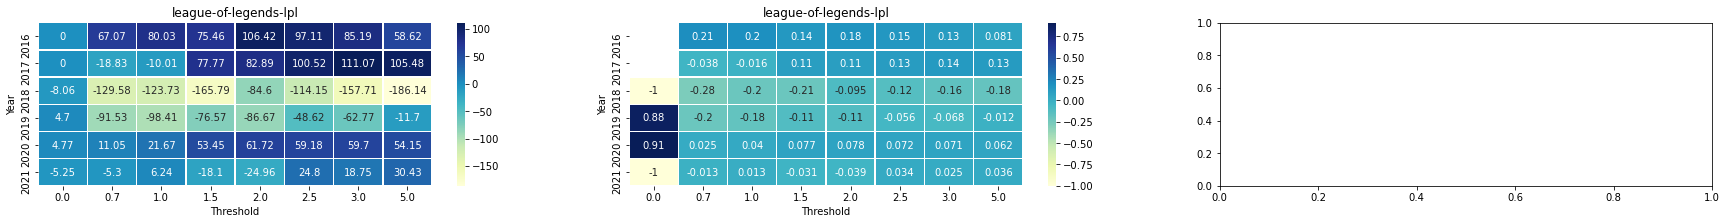

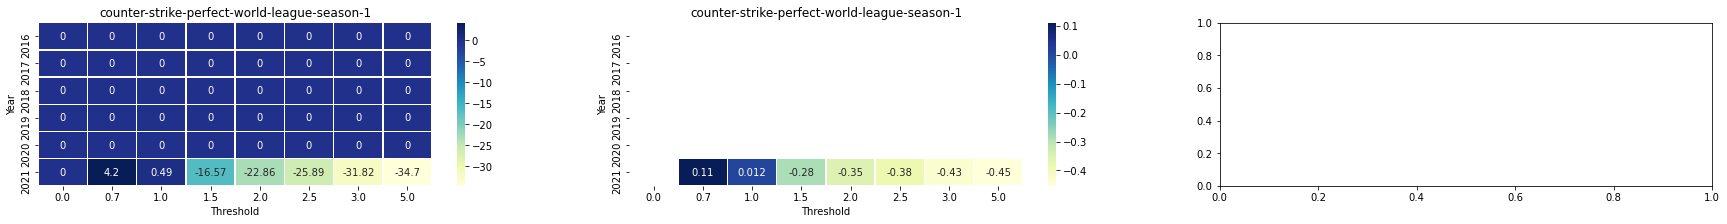

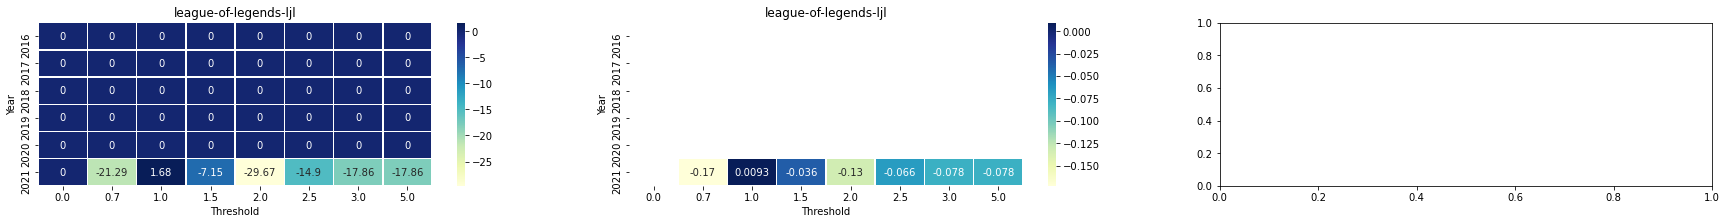

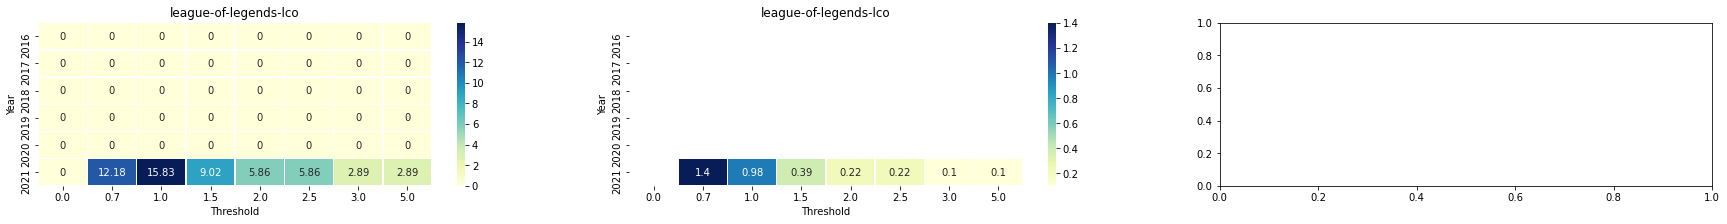

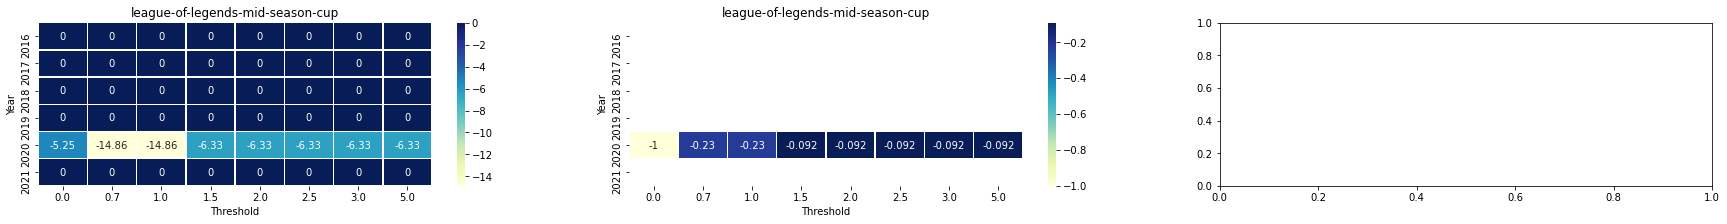

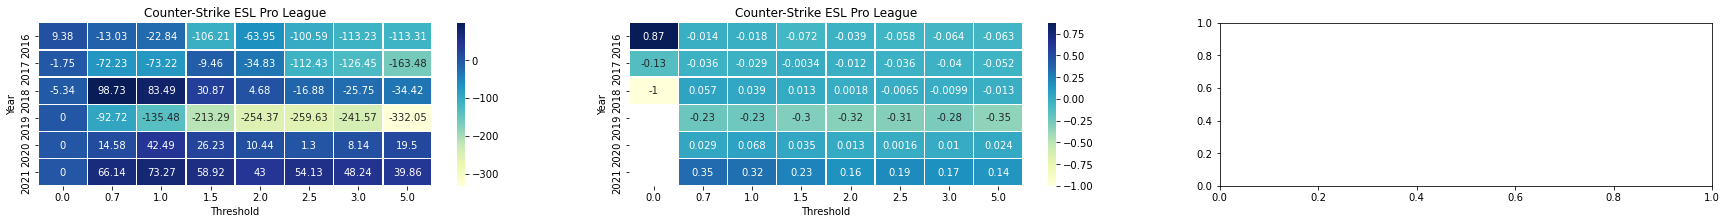

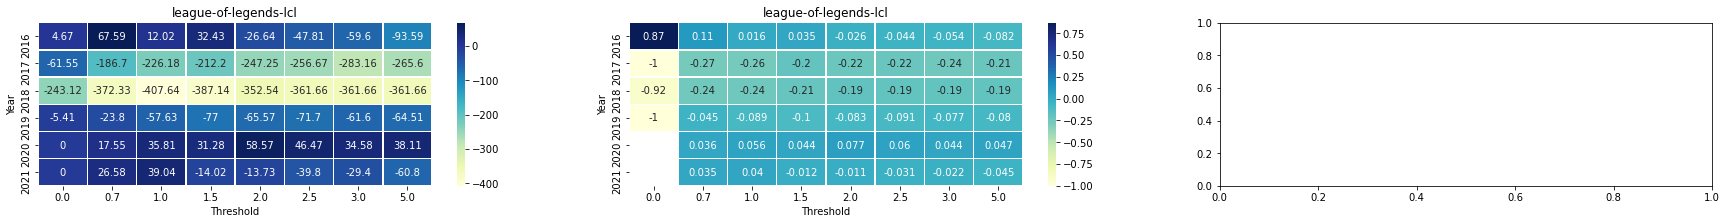

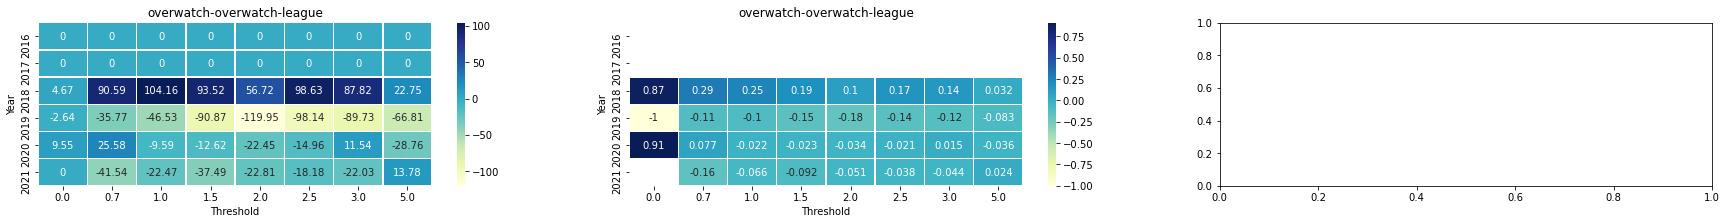

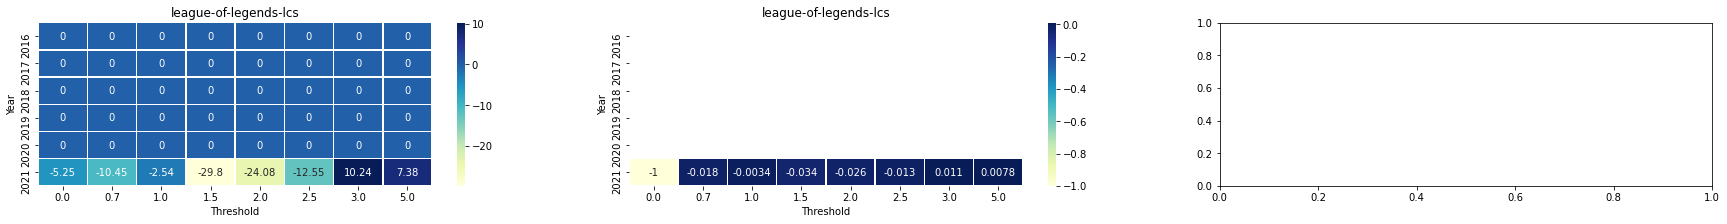

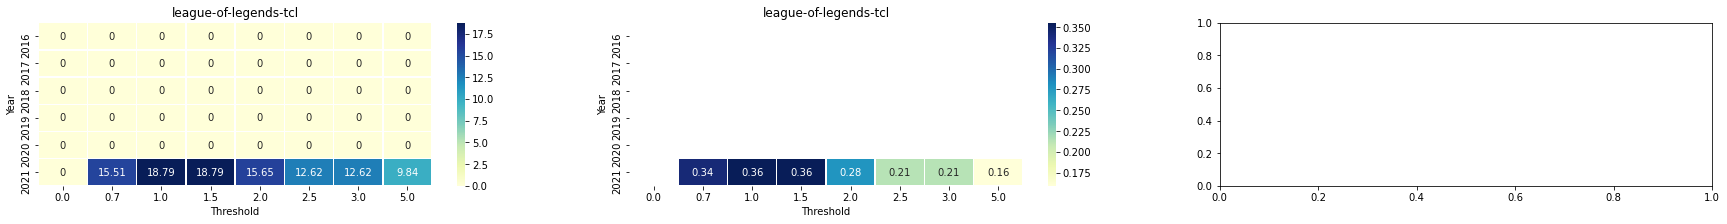

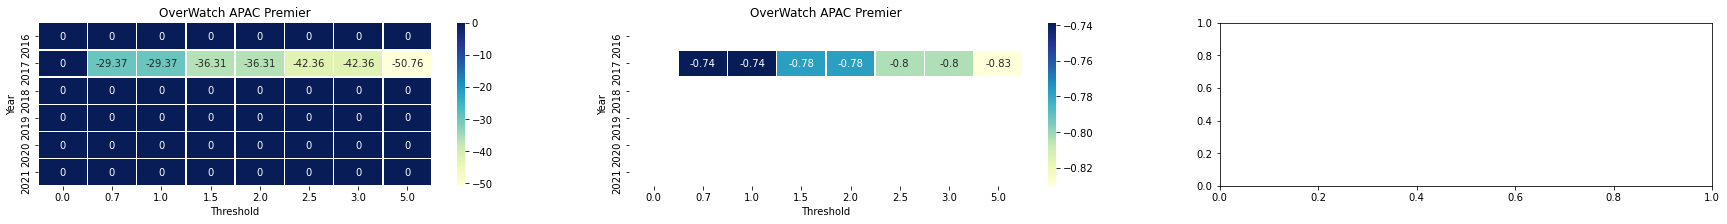

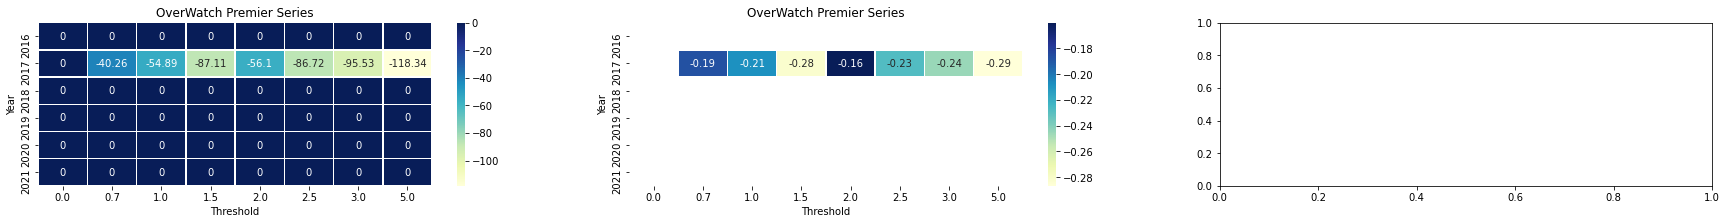

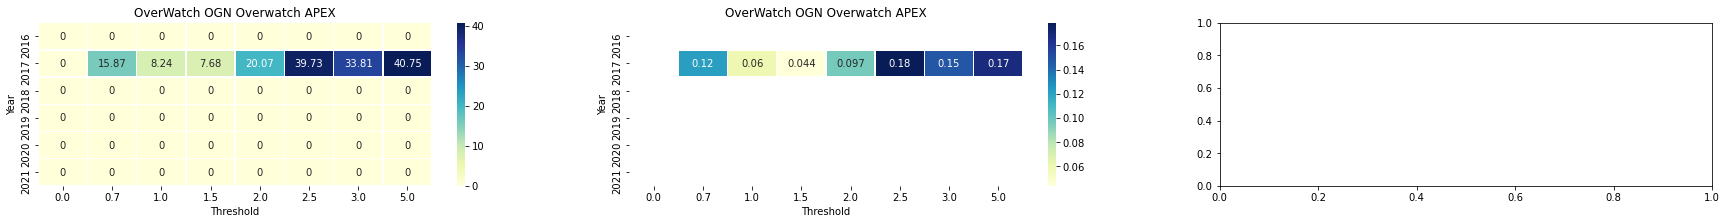

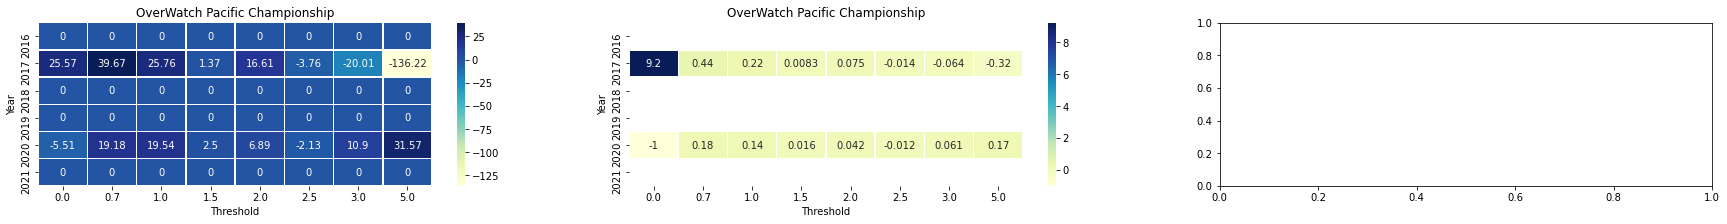

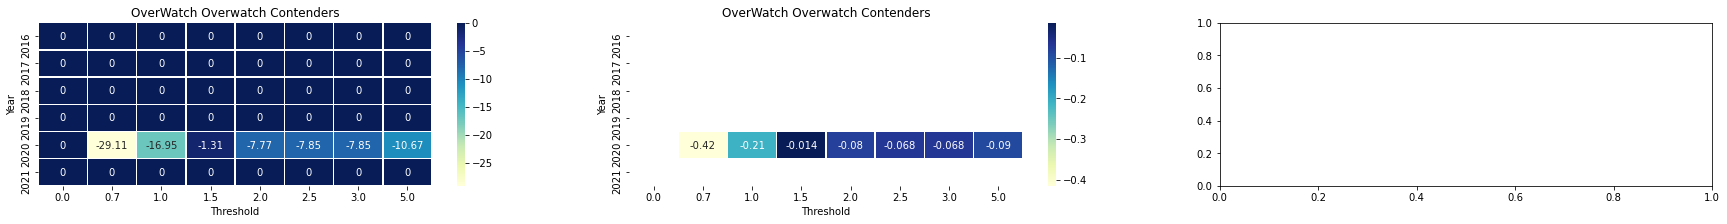

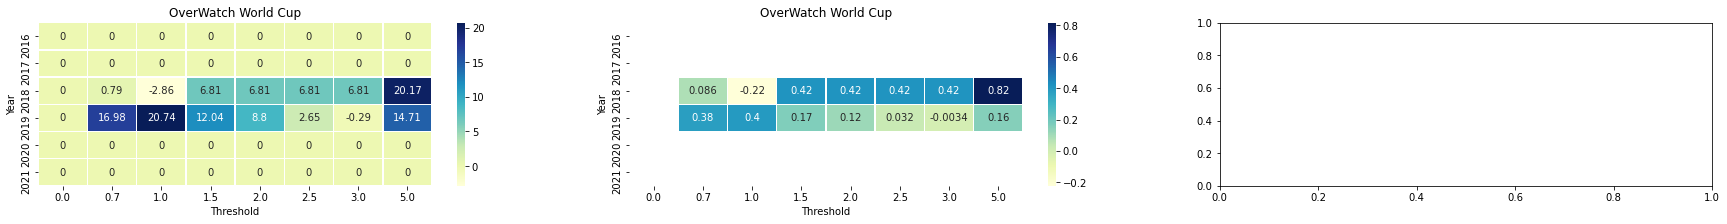

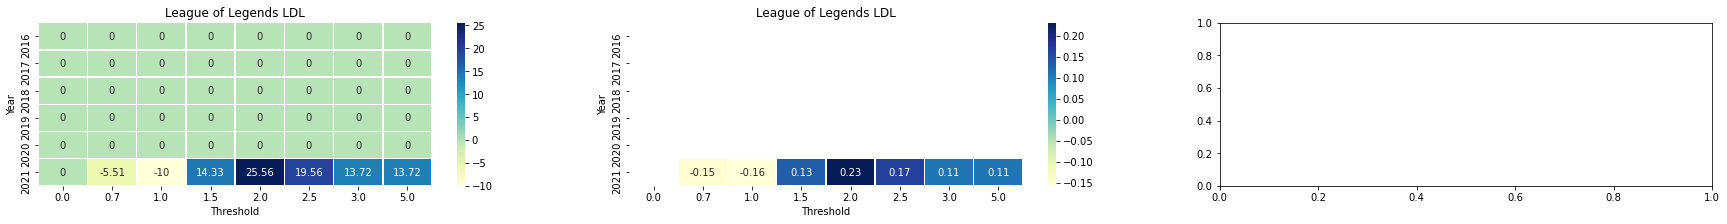

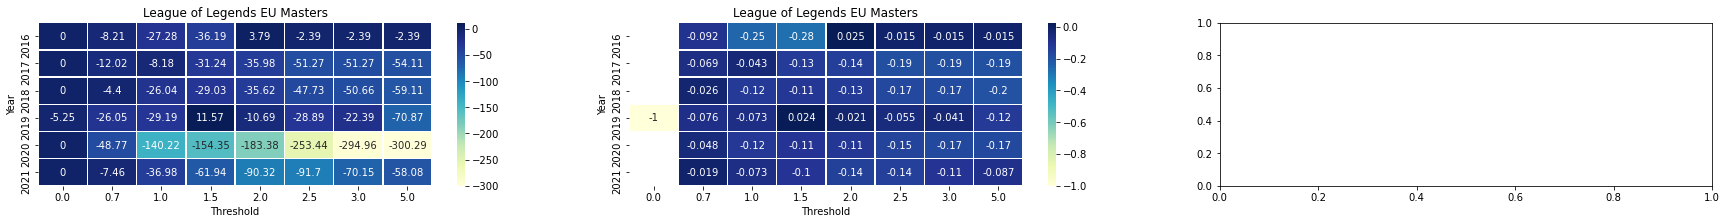

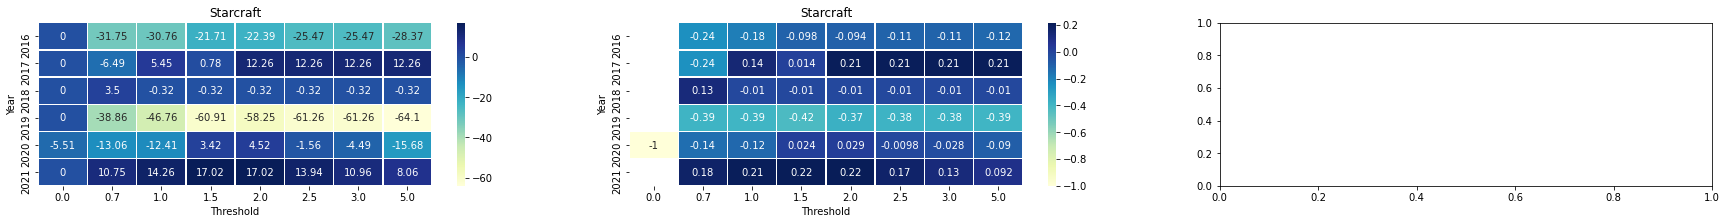

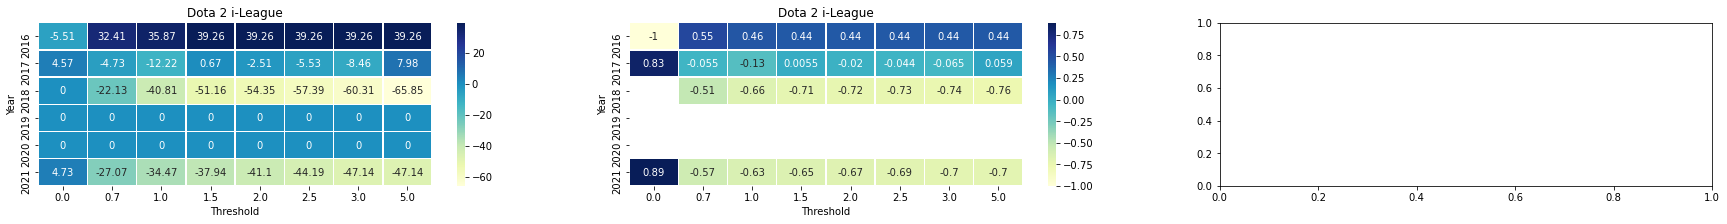

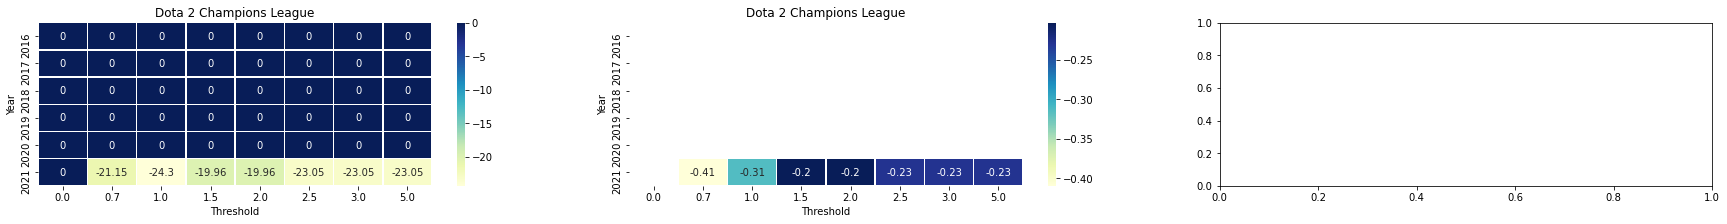

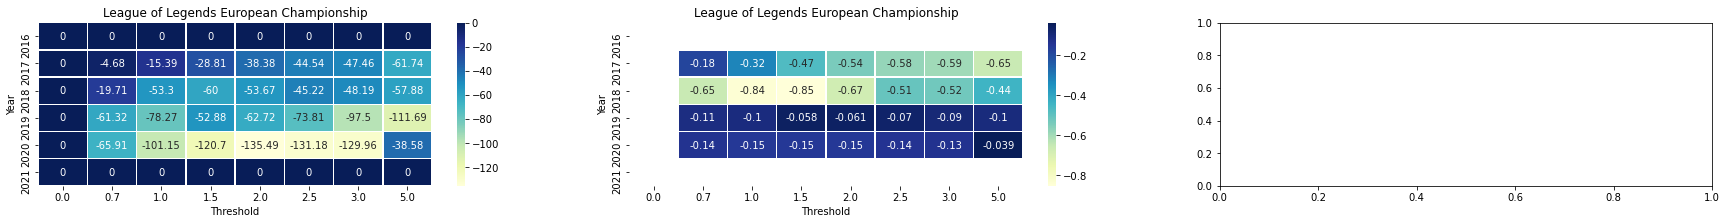

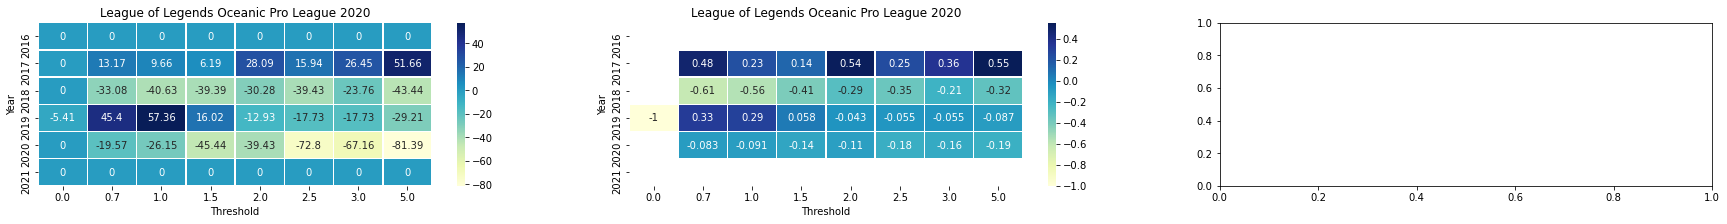

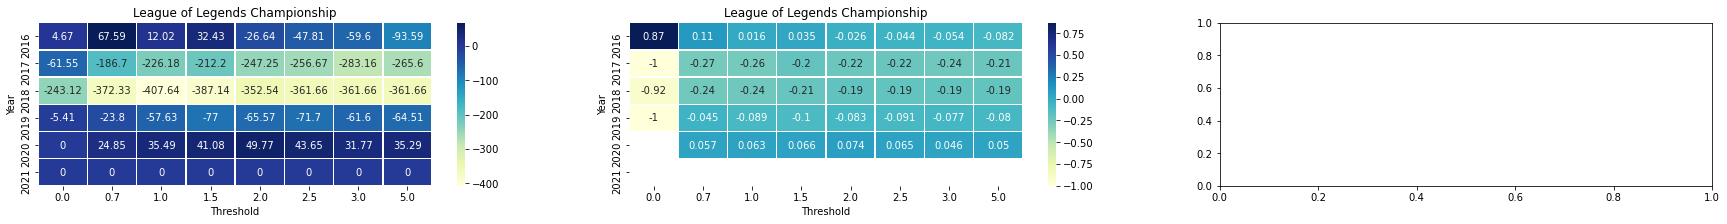

In [31]:
#BiggerOdds & Smaller than threshold:
i = 0
plt.rcParams["figure.figsize"] = (30,3)

for league in leagues:
    df_results = pd.DataFrame(columns=["Year", "Div", "Threshold", "ProfitOnBig", "Profit_pct", "Profit_cnt"])
    i += 1
    for years in range(2016, 2022):
        div = (df["Div"] == league)
        year = (df["Year"] == years)
        i += 1
        for threshold in thresholds:
            std_range = (df["STD"] <= threshold)
            df_filtered = df[year & div & std_range]
            profit = df_filtered["ProfitOnBig"].sum()
            profit_pct = df_filtered["ProfitOnBig"].sum() / df_filtered["StakeBig"].sum()
            #profit_cnt = df_filtered["ProfitOnBig"].sum() / profit_pct
            new_row = pd.Series({"Year":years, "Div":league, "Threshold":threshold, "Profit":round(profit,2), "Profit_pct":profit_pct})
            df_results = df_results.append(new_row, ignore_index=True)
            i += 1
    fig, ax = plt.subplots(1,3)
    sns.heatmap(df_results.pivot("Year", "Threshold", "Profit"), cmap="YlGnBu", annot=True, fmt="g", linewidths=0.5, ax=ax[0]).set(title=league)
    sns.heatmap(df_results.pivot("Year", "Threshold", "Profit_pct"), cmap="YlGnBu", annot=True, linewidths=0.5, ax=ax[1]).set(title=league)
    #sns.heatmap(df_results.pivot("Year", "Threshold", "Profit_cnt"), cmap="YlGnBu", annot=True, fmt="g", linewidths=0.5, ax=ax[2]).set(title=league)
    fig.show()

### Filter by Game & | Date

In [73]:
df = df[df["Div"].str.contains("league-of-legends")]

In [ ]:
df = df[df['Date'] > "2021-04-01"]

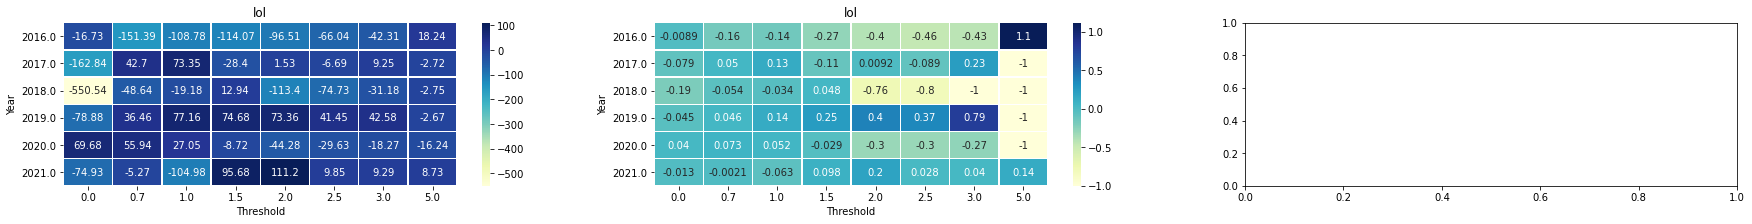

In [74]:
#BiggerOdds & Bigger than threshold for all LOL matches:

i = 0
plt.rcParams["figure.figsize"] = (30,3)

for _ in [_]:
    df_results = pd.DataFrame(columns=["Date", "Threshold", "ProfitOnBig", "Profit_pct", "Profit_cnt"])
    i += 1
    for year in range(2016, 2022):
        date = (df["Date"] == year)
        i += 1
        for threshold in thresholds:
            std_range = (df["STD"] >= threshold)
            df_filtered = df[date & std_range]
            profit = df_filtered["ProfitOnBig"].sum()
            profit_pct = df_filtered["ProfitOnBig"].sum() / df_filtered["StakeBig"].sum()
            #profit_cnt = df_filtered["ProfitOnBig"].sum() / profit_pct
            new_row = pd.Series({"Year":year, "Threshold":threshold, "Profit":round(profit,2), "Profit_pct":profit_pct})
            df_results = df_results.append(new_row, ignore_index=True)
            i += 1
    fig, ax = plt.subplots(1,3)
    sns.heatmap(df_results.pivot("Year", "Threshold", "Profit"), cmap="YlGnBu", annot=True, fmt="g", linewidths=0.5, ax=ax[0]).set(title="lol")
    sns.heatmap(df_results.pivot("Year", "Threshold", "Profit_pct"), cmap="YlGnBu", annot=True, linewidths=0.5, ax=ax[1]).set(title="lol")
    #sns.heatmap(df_results.pivot("Year", "Threshold", "Profit_cnt"), cmap="YlGnBu", annot=True, fmt="g", linewidths=0.5, ax=ax[2]).set(title=league)
    fig.show()
    

In [54]:
df.head()

,Div,Date,OddWins,STD,MAX,MIN,StakeBig,WinOnBig,StakeSmall,WinOnSmall,ProfitOnBig,ProfitOnSmall
0,league-of-legends-lck,2021,Small,0.625,2.72,1.47,3.953488,0.000000,7.819149,11.494149,-3.953488,3.675000
1,league-of-legends-lck,2021,Small,1.500,4.23,1.23,3.273994,0.000000,13.369565,16.444565,-3.273994,3.075000
2,league-of-legends-lck,2021,Big,0.285,2.24,1.67,4.516129,10.116129,6.231343,0.000000,5.600000,-6.231343
3,league-of-legends-lck,2021,Small,0.505,2.54,1.53,4.123377,0.000000,7.216981,11.041981,-4.123377,3.825000
4,league-of-legends-lck,2021,Small,3.475,8.04,1.09,2.855114,0.000000,30.277778,33.002778,-2.855114,2.725000


In [257]:
df.shape

(35790, 5)

In [55]:
df["Profit"].sum()

-713.556

In [254]:
df

,Div,Date,HomeFave,Profit,STD
0,BL2,2021,1,1.160,0.946185
2,BL2,2021,1,0.896,1.368368
3,BL2,2021,1,1.112,0.978905
4,BL2,2020,1,-1.000,0.292771
5,BL2,2020,1,-1.000,0.510129
...,...,...,...,...,...
53251,Sweden Allsvenskan,2021,1,0.570,2.127925
53252,Sweden Allsvenskan,2021,1,0.590,1.715232
53253,Sweden Allsvenskan,2021,1,-1.000,0.311163
53254,Sweden Allsvenskan,2021,1,0.390,2.959824
